<div style="display: flex; align-items: center;">
    <div style="display: flex; flex-direction: column; align-items: center;">
        <h1 style="text-align: right;">Centro de Investigación en Matemáticas, A.C.</h1>
        <h2 style="text-align: right;">Reconocimiento de Patrones</h2>
        <h2 style="text-align: right;">Jose Miguel Saavedra Aguilar</h2>
        <h3 style="text-align: right;">Examen 2. Ejercicio 3</h3>
    </div>
    <img src="Figures\logoCIMAT11.png" alt="CIMAT Logo" width="200" style="float: left;">
</div>


---

Importamos los paquetes que utilizaremos

In [1]:
# Import necessary libraries for data manipulation, visualization, and modeling
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # For pairplot and heatmap visualizations
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score  # Evaluation metrics
from sklearn.linear_model import LogisticRegression  # (Duplicate, but harmless)
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Decision Tree model and visualization
from sklearn.svm import SVC  # Support Vector Machine
from sklearn.preprocessing import MinMaxScaler  # Feature scaling
import tensorflow as tf  # Deep learning framework
from tensorflow.keras import layers, models  # For building neural networks

# Set random seed for reproducibility
np.random.seed(2025)

Cargamos el csv a un dataframe y quitamos los datos de ingreso y de riesgo, manteniendo los escalados.

In [2]:
# Load the dataset and set the first column as index
X_df = pd.read_csv('./seguro_datos.csv', index_col=0)
# Remove scaled columns to keep only original features
X_df.drop(columns=['ingreso_s', 'riesgo_s'], inplace=True)

De previas exploraciones, notamos que el ingreso es no negativo y aglomerado cerca al cero, por  lo que lo transformamos a $\mathbb{R}$ mediante la transformación logaritmo.

In [3]:
# Apply log transformation to 'ingreso' to spread out values
X_df['ingreso'] = np.log(X_df['ingreso'])
# Invert 'sexo' so that 1 = female, 0 = male (if originally 1 = male)
X_df['sexo'] = 1 - X_df['sexo']

Reescalamos los datos a un rango de $[0,1]$ para que el modelo no se vea afectado por la escala de los datos.

In [4]:
# Rescale features again after transformation to keep all in [0,1]
scaler = MinMaxScaler()
X_df = pd.DataFrame(scaler.fit_transform(X_df), columns=['ingreso', 'sexo', 'riesgo', 'casado', 'siniestro'])

A continuación, mostramos un pairplot de los datos, donde vemos que el riesgo transformado tiene forma de campana, lo que es una buena señal para el modelo, mientras que el riesgo parece tener una distribución uniforme. También notamos que el ingreso en las personas que no reportan un siniestro está concentrado en un rango alto, mientras que las personas que sí reportan un siniestro tienen un ingreso más disperso y en un rango más bajo.

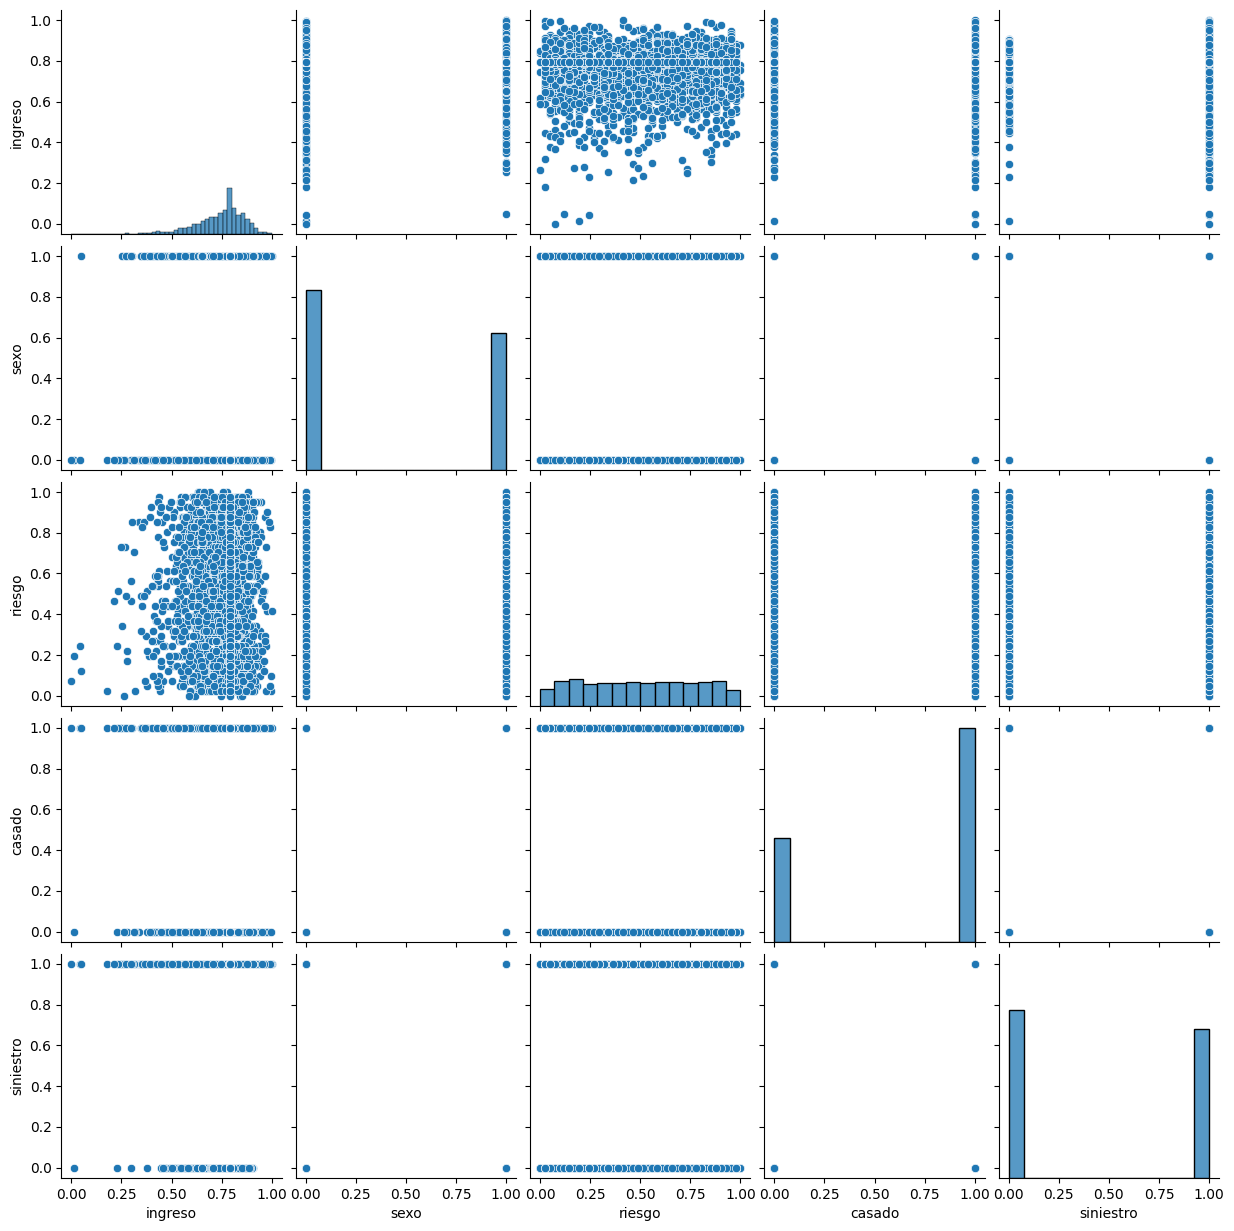

In [5]:
# Visualize pairwise relationships between features
sns.pairplot(X_df)


Seguimos con un heatmap de la correlación entre las variables, donde vemos que el ingreso tiene una correlación negativa con los siniestros, mientras que el riesgo tiene una correlación positiva con los siniestros, al igual que el sexo con los siniestros. Esto es consistente con la intuición de que las personas con un ingreso más alto tienden a reportar menos siniestros, además que el riesgo calculado por la aseguradora es un buen predictor de los siniestros.

<Axes: >

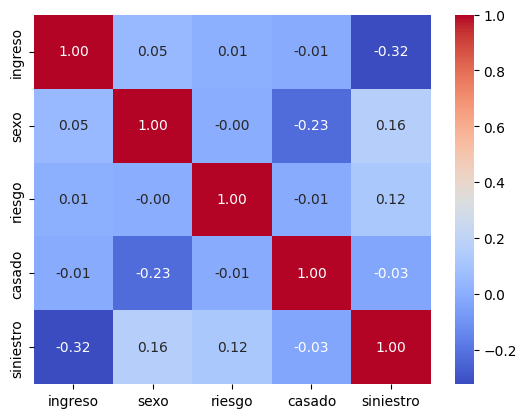

In [6]:
# Show correlation matrix between features
sns.heatmap(X_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')

Para observar la posible influencia que tiene el sexo en los reportes de siniestros, mostramos un heatmap de los siniestros por sexo, donde vemos que en las personas que reportan siniestro hay una proporción similar de hombres y mujeres, mientras que las personas que no reportan siniestros son en su mayoría hombres. Esto puede ser un indicativo de que las mujeres tienden a tener más siniestros, o a reportarlos.

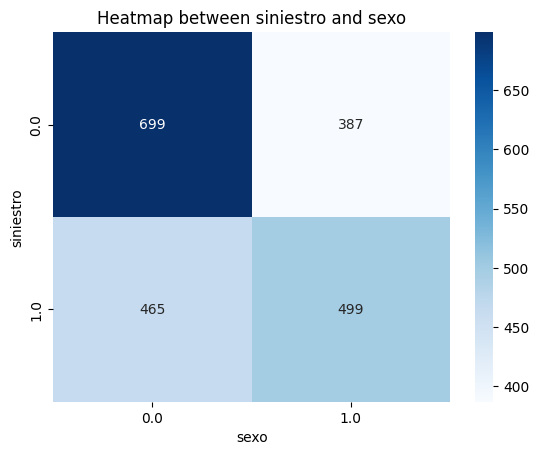

In [7]:
# Visualize the relationship between 'siniestro' and 'sexo'
sns.heatmap(pd.crosstab(X_df['siniestro'], X_df['sexo']), annot=True, cmap='Blues', fmt='d')
plt.xlabel('sexo')
plt.ylabel('siniestro')
plt.title('Heatmap between siniestro and sexo')
plt.show()

Para comparar, mostramos un heatmap de los siniestros por estado civil, donde vemos una proporción similar de solteros y casados en los dos casos. Esto sugiere que el estado civil no tiene un impacto significativo en la probabilidad de reportar un siniestro.

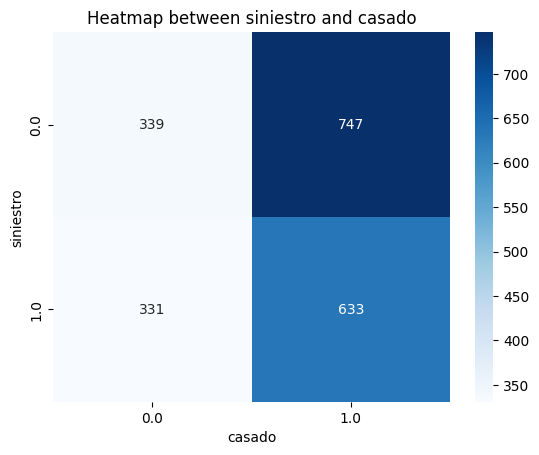

In [8]:
# Visualize the relationship between 'siniestro' and 'casado'
sns.heatmap(pd.crosstab(X_df['siniestro'], X_df['casado']), annot=True, cmap='Blues', fmt='d')
plt.xlabel('casado')
plt.ylabel('siniestro')
plt.title('Heatmap between siniestro and casado')
plt.show()

Para predecir los siniestros, preparamos los datos, separando las variables predictoras de la variable objetivo, que es el siniestro. Luego, dividimos los datos en un conjunto de entrenamiento y un conjunto de prueba, para poder evaluar los modelos.

In [9]:
# Separate predictors and target variable, drop missing values
X = X_df.drop(columns=['siniestro']).dropna()
y = X_df.loc[X.index, 'siniestro']

# Split data into training and test sets (80/20 split, stratified by target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)

Como primer aproximación, tomemos la regresión logística. Medimos la precisión del modelo en el conjunto de prueba, y obtenemos una puntuación balanceada de 0.7135, lo que indica que el modelo tiene un buen desempeño en la clasificación de los siniestros. Más aún, la precisión es similar en ambos conjuntos, lo que sugiere que el modelo no está sobreajustado.


In [10]:
# Train a balanced logistic regression model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2025)
logreg.fit(X_train, y_train)

# Predict on test set
y_logreg = logreg.predict(X_test)

# Compute confusion matrix and balanced accuracy
conf_matrix_logreg = confusion_matrix(y_test, y_logreg)
score_logreg = balanced_accuracy_score(y_test, y_logreg)

# Print classification report and accuracy
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_logreg))
print(f"Model Accuracy (Logistic Regression): {score_logreg:.4f}")

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74       217
         1.0       0.72      0.65      0.68       193

    accuracy                           0.72       410
   macro avg       0.72      0.71      0.71       410
weighted avg       0.72      0.72      0.72       410

Model Accuracy (Logistic Regression): 0.7135


Posteriormente, tomamos una máquina de soporte vectorial (SVM) con un kernel lineal. La puntuación balanceada en el conjunto de prueba es de 0.7124, lo que es similar a la regresión logística. Sin embargo, la SVM tiene una precisión mayor de verdaderos positivos, mientras que tiene menor precisión de verdaderos negativos. Esto sugiere que la SVM está prediciendo más siniestros que la realidad, lo que no es ideal para los clientes de la aseguradora, que pueden ver sus primas incrementadas por un error de este tipo.

In [11]:
# Train a linear SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train, y_train)

# Predict on test set
y_svm = svm_classifier.predict(X_test)

# Compute confusion matrix and balanced accuracy
conf_matrix_svm = confusion_matrix(y_test, y_svm)
score_svm = balanced_accuracy_score(y_test, y_svm)

# Print classification report and accuracy
print("Classification Report (Support Vector Machine):")
print(classification_report(y_test, y_svm))
print(f"Model Accuracy (Support Vector Machine): {score_svm:.4f}")

Classification Report (Support Vector Machine):
              precision    recall  f1-score   support

         0.0       0.69      0.88      0.77       217
         1.0       0.80      0.55      0.65       193

    accuracy                           0.72       410
   macro avg       0.74      0.71      0.71       410
weighted avg       0.74      0.72      0.71       410

Model Accuracy (Support Vector Machine): 0.7124


Ahora, tomamos un árbol de decisión, el cual podaremos para evitar el sobreajuste.


In [12]:
# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get pruning path and alphas for cost-complexity pruning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

# Train a tree for each alpha value
clfs = [DecisionTreeClassifier(ccp_alpha=alpha, random_state=42).fit(X_train, y_train) for alpha in ccp_alphas]

# Evaluate train and test scores for each pruned tree
train_scores = [balanced_accuracy_score(y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

# Select the alpha with the best test score
best_alpha = ccp_alphas[np.argmax(test_scores)]
print(f"Optimal ccp_alpha: {best_alpha:.6f}")

# Retrain the pruned tree with optimal alpha
clf_pruned = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)

Optimal ccp_alpha: 0.002549


De esta forma, el $\alpha$ óptimo es 0.008224, lo que nos da un árbol de decisión con una puntuación balanceada de 0.7599 en el conjunto de prueba, con precisión de verdaderos positivos de 0.73 y precisión de verdaderos negativos de 0.79. Esto sugiere que el árbol de decisión es el que mejor predice los siniestros hasta el momento, con una buena precisión en ambos casos.

In [13]:
# Fit the pruned decision tree and evaluate on test set
clf_pruned.fit(X_train, y_train)
y_clf = clf_pruned.predict(X_test)

# Compute confusion matrix and balanced accuracy
conf_matrix_clf = confusion_matrix(y_test, y_clf)
score_clf = balanced_accuracy_score(y_test, y_clf)

# Print classification report and accuracy
print("Classification Report (Pruned Tree Classifier):")
print(classification_report(y_test, y_clf))
print(f"Model Accuracy (Pruned Tree Classifier): {score_clf:.4f}")

Classification Report (Pruned Tree Classifier):
              precision    recall  f1-score   support

         0.0       0.79      0.74      0.76       217
         1.0       0.73      0.78      0.75       193

    accuracy                           0.76       410
   macro avg       0.76      0.76      0.76       410
weighted avg       0.76      0.76      0.76       410

Model Accuracy (Pruned Tree Classifier): 0.7599


Observamos el árbol de decisión, donde vemos que la mayoría de las decisiones se toman en base al ingreso, siendo 7 de las 11 decisiones basadas en esta variable, mientras que el sexo y el riesgo son utilizadas en 2 ocasiones cada una. Esto sugiere que el ingreso es la variable más importante para predecir los siniestros, lo cual es consistente con la intuición de que las personas con un ingreso más alto tienden a reportar menos siniestros.

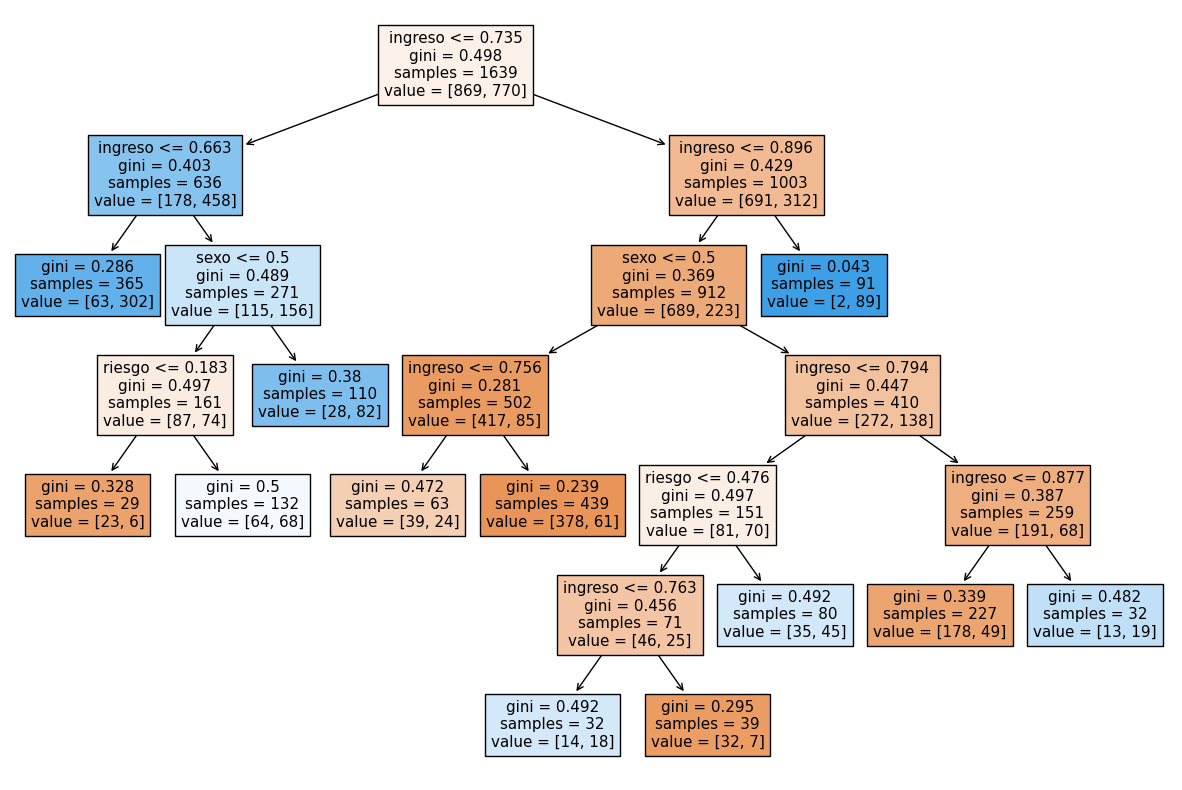

In [14]:
# Visualize the pruned decision tree
plt.figure(figsize=(15, 10))
plot_tree(clf_pruned, feature_names=X_test.columns, filled=True)
plt.show()

# Medidas de justicia
La justicia (fairness) de los modelos puede ser medida utilizando las primeras cuatro definiciones de Mehrabi et al. (2021), que son:
1. **Equalized Odds**: La tasa de verdaderos positivos y la tasa de falsos positivos deben ser iguales para el grupo protegido y el grupo favorecido.
2. **Equal Opportunity**: La tasa de verdaderos positivos debe ser igual para el grupo protegido y el grupo favorecido.
3. **Demographic Parity**: La tasa de positivos debe ser igual para el grupo protegido y el grupo favorecido.
4. **Fairness through Awareness**: El modelo debe dar predicciones similares para individuos similares, independientemente de su grupo protegido.

Para hacerlo, creamos una clase que implementa estas medidas de justicia, y las aplicamos a los modelos entrenados.

In [15]:
class FairnessMetrics:
    """
    A class to calculate various fairness metrics for machine learning models based on A Survey on Bias and Fairness in Machine Learning by Ninareh Mehrabi et al.
    """

    def _calculate_rates(self, y_true, y_pred, protected_attribute, group_val):
        """Helper method to calculate TP, FP, TN, FN for a specific group."""
        group_mask = (protected_attribute == group_val)

        if not np.any(group_mask):  # No individuals in this group
            return 0, 0, 0, 0, 0, 0  # TP, FP, TN, FN, P, N

        y_true_group = y_true[group_mask]
        y_pred_group = y_pred[group_mask]

        tp = np.sum((y_true_group == 1) & (y_pred_group == 1))
        fp = np.sum((y_true_group == 0) & (y_pred_group == 1))
        tn = np.sum((y_true_group == 0) & (y_pred_group == 0))
        fn = np.sum((y_true_group == 1) & (y_pred_group == 0))

        actual_positives = tp + fn
        actual_negatives = fp + tn

        return tp, fp, tn, fn, actual_positives, actual_negatives

    def measure_equalized_odds(self, y_true, y_pred, protected_attribute,
                               privileged_group_val=0, unprivileged_group_val=1):
        """
        Measures Equalized Odds. Definition 1 from the paper.
        Requires TPR and FPR to be equal across groups.

        Args:
            y_true (np.array): True binary labels (0 or 1).
            y_pred (np.array): Predicted binary labels (0 or 1).
            protected_attribute (np.array): Array indicating group membership.
            privileged_group_val: Value for the privileged group.
            unprivileged_group_val: Value for the unprivileged group.

        Returns:
            dict: {'tpr_difference': TPR(unpriv) - TPR(priv),
                   'fpr_difference': FPR(unpriv) - FPR(priv)}
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        protected_attribute = np.asarray(protected_attribute)

        tp_priv, fp_priv, _, _, p_priv, n_priv = self._calculate_rates(
            y_true, y_pred, protected_attribute, privileged_group_val
        )
        tpr_priv = tp_priv / p_priv if p_priv > 0 else 0
        fpr_priv = fp_priv / n_priv if n_priv > 0 else 0

        tp_unpriv, fp_unpriv, _, _, p_unpriv, n_unpriv = self._calculate_rates(
            y_true, y_pred, protected_attribute, unprivileged_group_val
        )
        tpr_unpriv = tp_unpriv / p_unpriv if p_unpriv > 0 else 0
        fpr_unpriv = fp_unpriv / n_unpriv if n_unpriv > 0 else 0

        return {
            "tpr_difference": tpr_unpriv - tpr_priv,
            "fpr_difference": fpr_unpriv - fpr_priv
        }

    def measure_equal_opportunity(self, y_true, y_pred, protected_attribute,
                                  privileged_group_val=0, unprivileged_group_val=1):
        """
        Measures Equal Opportunity. Definition 2 from the paper.
        Requires TPR to be equal across groups.

        Args:
            y_true (np.array): True binary labels.
            y_pred (np.array): Predicted binary labels.
            protected_attribute (np.array): Group membership.
            privileged_group_val: Value for the privileged group.
            unprivileged_group_val: Value for the unprivileged group.

        Returns:
            float: TPR(unprivileged) - TPR(privileged).
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        protected_attribute = np.asarray(protected_attribute)

        tp_priv, _, _, _, p_priv, _ = self._calculate_rates(
            y_true, y_pred, protected_attribute, privileged_group_val
        )
        tpr_priv = tp_priv / p_priv if p_priv > 0 else 0

        tp_unpriv, _, _, _, p_unpriv, _ = self._calculate_rates(
            y_true, y_pred, protected_attribute, unprivileged_group_val
        )
        tpr_unpriv = tp_unpriv / p_unpriv if p_unpriv > 0 else 0

        return tpr_unpriv - tpr_priv

    def measure_demographic_parity(self, y_pred, protected_attribute,
                                   privileged_group_val=0, unprivileged_group_val=1):
        """
        Measures Demographic Parity (Statistical Parity). Definition 3 from the paper.
        Requires the rate of positive predictions to be equal across groups.

        Args:
            y_pred (np.array): Predicted binary labels.
            protected_attribute (np.array): Group membership.
            privileged_group_val: Value for the privileged group.
            unprivileged_group_val: Value for the unprivileged group.

        Returns:
            float: Rate(unprivileged) - Rate(privileged).
        """
        y_pred = np.asarray(y_pred)
        protected_attribute = np.asarray(protected_attribute)

        mask_priv = (protected_attribute == privileged_group_val)
        num_priv = np.sum(mask_priv)
        positive_preds_priv = np.sum(y_pred[mask_priv] == 1)
        rate_priv = positive_preds_priv / num_priv if num_priv > 0 else 0

        mask_unpriv = (protected_attribute == unprivileged_group_val)
        num_unpriv = np.sum(mask_unpriv)
        positive_preds_unpriv = np.sum(y_pred[mask_unpriv] == 1)
        rate_unpriv = positive_preds_unpriv / num_unpriv if num_unpriv > 0 else 0

        return rate_unpriv - rate_priv

    def measure_fairness_through_awareness(self, X, y_pred, similarity_function,
                                           similarity_threshold):
        """
        Measures Fairness through Awareness. Definition 4 from the paper.
        Calculates the proportion of similar pairs of individuals that receive
        different outcomes. This metric requires a similarity function
        to determine how similar two individuals are based on their features.

        Args:
            X (np.array): Feature matrix (n_samples, n_features).
            y_pred (np.array): Predicted labels (n_samples,).
            similarity_function (callable): Function(vec1, vec2) -> float similarity.
            similarity_threshold (float): Threshold for similarity.

        Returns:
            float: Proportion of similar pairs with different predictions. 0 is ideal.
                   Returns 0 if no similar pairs are found.
        """
        X = np.asarray(X)
        y_pred = np.asarray(y_pred)
        n_samples = X.shape[0]

        if n_samples < 2:
            return 0.0

        dissimilar_outcomes_for_similar_pairs = 0
        similar_pairs_count = 0

        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                sim_score = similarity_function(X[i], X[j])
                if sim_score >= similarity_threshold:
                    similar_pairs_count += 1
                    if y_pred[i] != y_pred[j]:
                        dissimilar_outcomes_for_similar_pairs += 1

        if similar_pairs_count == 0:
            return 0.0

        return dissimilar_outcomes_for_similar_pairs / similar_pairs_count



Como último modelo, utiliaremos una red neuronal de keras con una capa oculta de 16 neuronas, que además tenga una función de pérdida personalizada que incluya la justicia (fairness) del modelo, más precisamente las primeras dos definiciones de justicia. Esto nos permitirá optimizar el modelo no solo por su precisión, sino también por su equidad en las predicciones. A continuación, mostramos la función de pérdida:

In [16]:
# Custom loss function for neural network that penalizes unfairness
# Includes Equal Opportunity and Equalized Odds as regularization terms
def fairness_loss(
    lambda_eo=0.25,
    lambda_eqopp=0.25
):
    """
    Custom loss with fairness penalties:
    - Demographic Parity (DP): difference in positive prediction rates.
    - Equalized Odds (EO): difference in TPR and FPR.
    - Equal Opportunity (EqOpp): difference in TPR.
    Assumes y_pred is shape (batch, 2): [:,0] is output_prob, [:,1] is protected_attribute.
    """
    def loss(y_true, y_pred):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, 2])
        y_prob = y_pred[:, 0]
        # Ensure protected attribute is boolean
        protected_attribute = tf.cast(tf.round(y_pred[:, 1]), tf.bool)

        # Standard binary cross-entropy loss
        bce = tf.keras.losses.binary_crossentropy(y_true, y_prob)

        # Masks for groups
        mask_priv = tf.logical_not(protected_attribute)
        mask_unpriv = protected_attribute

        # Equal Opportunity (EqOpp): TPR difference
        # Ensure y_true has a shape compatible with boolean_mask
        y_true_reshaped = tf.cast(tf.reshape(y_true, [-1]), tf.bool) # Cast to bool for masking comparison
        tpr_mask_priv = tf.logical_and(mask_priv, y_true_reshaped)
        tpr_mask_unpriv = tf.logical_and(mask_unpriv, y_true_reshaped)

        num_true_pos_priv = tf.reduce_sum(tf.cast(tpr_mask_priv, tf.float32))
        # Calculate actual positives for the privileged group
        actual_positives_priv = tf.reduce_sum(tf.cast(tf.boolean_mask(y_true_reshaped, mask_priv), tf.float32))
        tpr_priv = tf.math.divide_no_nan(num_true_pos_priv, actual_positives_priv)

        num_true_pos_unpriv = tf.reduce_sum(tf.cast(tpr_mask_unpriv, tf.float32))
        # Calculate actual positives for the unprivileged group
        actual_positives_unpriv = tf.reduce_sum(tf.cast(tf.boolean_mask(y_true_reshaped, mask_unpriv), tf.float32))
        tpr_unpriv = tf.math.divide_no_nan(num_true_pos_unpriv, actual_positives_unpriv)

        eqopp_diff = tf.square(tpr_unpriv - tpr_priv)

        # Equalized Odds (EO): TPR and FPR difference
        fpr_mask_priv = tf.logical_and(mask_priv, tf.logical_not(y_true_reshaped))
        fpr_mask_unpriv = tf.logical_and(mask_unpriv, tf.logical_not(y_true_reshaped))

        num_false_pos_priv = tf.reduce_sum(tf.cast(fpr_mask_priv, tf.float32))
        # Calculate actual negatives for the privileged group
        actual_negatives_priv = tf.reduce_sum(tf.cast(tf.logical_not(tf.boolean_mask(y_true_reshaped, mask_priv)), tf.float32))
        fpr_priv = tf.math.divide_no_nan(num_false_pos_priv, actual_negatives_priv)

        num_false_pos_unpriv = tf.reduce_sum(tf.cast(fpr_mask_unpriv, tf.float32))
        # Calculate actual negatives for the unprivileged group
        actual_negatives_unpriv = tf.reduce_sum(tf.cast(tf.logical_not(tf.boolean_mask(y_true_reshaped, mask_unpriv)), tf.float32))
        fpr_unpriv = tf.math.divide_no_nan(num_false_pos_unpriv, actual_negatives_unpriv)

        eo_diff = tf.square(fpr_unpriv - fpr_priv)

        # Total loss: binary cross-entropy + fairness penalties
        return bce + lambda_eqopp * eqopp_diff + lambda_eo * eo_diff

    return loss

Ahora, construimos la red neuronal, donde utilizamos la función de pérdida personalizada que incluye la justicia (fairness) del modelo, y a continuación mostramos el resumen del modelo:

In [17]:
# Build a neural network with a custom fairness loss
inputs = layers.Input(shape=(X_train.shape[1],), name='features')  # All features including 'sexo'

# Extract the protected attribute (sexo) for fairness loss
protected_attribute = inputs[:, 1:2]

# Hidden layer with 16 neurons
x = layers.Dense(16, activation='relu')(inputs)
# Output layer for probability
output_prob = layers.Dense(1, activation='sigmoid')(x)

# Concatenate output probability and protected attribute for custom loss
outputs = layers.Concatenate(axis=1)([output_prob, protected_attribute])

# Define and compile the model
model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss=fairness_loss())

# Show model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 features (InputLayer)       [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 16)                   80        ['features[0][0]']            
                                                                                                  
 dense_1 (Dense)             (None, 1)                    17        ['dense[0][0]']               
                                                                                                  
 tf.__operators__.getitem (  (None, 1)                    0         ['features[0][0]']            
 SlicingOpLambda)                                                                             

Entrenamos la red neuronal:

In [18]:
# Train the neural network with fairness-aware loss
model.fit(X_train, y_train, epochs=500, batch_size=32)

Epoch 1/500
52/52 [==============================] - 3s 6ms/step - loss: 0.7117
Epoch 2/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6977
Epoch 3/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6923
Epoch 4/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6877
Epoch 5/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6824
Epoch 6/500
52/52 [==============================] - 0s 6ms/step - loss: 0.6801
Epoch 7/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6764
Epoch 8/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6727
Epoch 9/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6674
Epoch 10/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6627
Epoch 11/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6610
Epoch 12/500
52/52 [==============================] - 0s 5ms/step - loss: 0.6591
Epoch 13/500
52/52 [=================

Predecimos los siniestros con la red neuronal, y obtenemos una puntuación balanceada de 0.7251 en el conjunto de prueba, similar al resto de los algoritmos. Sin embargo, la red neuronal tiene una precisión de verdaderos positivos de 0.77 y una precisión de verdaderos negativos de 0.71. Si bien, esta no es la mejor precisión de todos los modelos, esperamos que la red neuronal sea más justa que los modelos anteriores, ya que fue entrenada con una función de pérdida que incluye la justicia (fairness).

In [19]:
# Predict with the neural network model
y_nn_raw = model.predict(X_test)
y_nn_prob = y_nn_raw[:, 0]  # Extract the probability (first column)

# Convert probabilities to binary predictions using threshold 0.5
y_nn = (y_nn_prob > 0.5).astype(int)

# Confusion Matrix for the neural network
conf_matrix_nn = confusion_matrix(y_test, y_nn)

# Model Accuracy for the neural network
score_nn = balanced_accuracy_score(y_test, y_nn)

# Classification Report for the neural network
print("Classification Report (Neural Network):")
print(classification_report(y_test, y_nn))
print(f"Model Accuracy (Neural Network): {score_nn:.4f}")

13/13 [==============================] - 0s 2ms/step
Classification Report (Neural Network):
              precision    recall  f1-score   support

         0.0       0.71      0.84      0.77       217
         1.0       0.77      0.61      0.68       193

    accuracy                           0.73       410
   macro avg       0.74      0.73      0.73       410
weighted avg       0.74      0.73      0.73       410

Model Accuracy (Neural Network): 0.7251


## Medida de semejanza
Para la definición de Fairness through Awareness, requerimos definir una métrica de semejanza entre individuos. Mehrabi et al. (2021) sugieren utilizar el inverso de la distancia euclidiana como medida de semejanza. Nosotros definimos una función que calcula para las variables numéricas $x_n$ y $y_n$ de $x$ y $y$ respectivamente la siguiente medida de semejanza:
$$
\operatorname{similarity}_n(x, y) = 1 - \frac{\|x_n-y_n\|}{\sqrt{|n|}}
$$
Donde la semejanza es 1 cuando los valores son iguales, y 0 cuando los valores son diferentes en el máximo posible, ya que $x$, $y$ están escaladas a $[0,1]$, de forma que a lo más la diferencia puede ser el número de variables numéricas, $|n|$. Además. para las variables categóricas, utilizamos la siguiente medida de semejanza:
$$
\operatorname{similarity}_c(x, y) = \frac{1}{|c|}\sum_c \mathbb{1}_{x_c = y_c}
$$
De forma que la semejanza total será:
$$
\operatorname{similarity}(x, y) = \alpha \operatorname{similarity}_n(x, y) + (1 - \alpha) \operatorname{similarity}_c(x, y)
$$

In [20]:
# Similarity function for Fairness through Awareness metric
def similarity_function(x1, x2):
    """
    Compute similarity between two individuals with features ordered as:
    ['ingreso', 'sexo', 'riesgo', 'casado']

    Parameters:
        x1, x2: np.array-like of shape (4,), ordered as above
        alpha: float in [0,1], weight for numerical vs. binary components

    Returns:
        similarity: float in [0,1]
    """
    alpha=0.5
    # Select numerical features: ingreso, riesgo
    x1_num = np.array([x1[0], x1[2]])
    x2_num = np.array([x2[0], x2[2]])

    # Select binary/categorical features: sexo, casado
    x1_bin = np.array([x1[1], x1[3]])
    x2_bin = np.array([x2[1], x2[3]])

    # Compute normalized Euclidean distance for numerical features
    num_distance = np.linalg.norm(x1_num - x2_num) / np.sqrt(2)  # assuming min-max scaling to [0,1]
    num_similarity = 1 - num_distance

    # Compute mean match for binary features
    bin_similarity = np.mean(x1_bin == x2_bin)

    # Weighted sum of similarities
    return alpha * num_similarity + (1 - alpha) * bin_similarity


## Medición de Fairness de los modelos

Finalmente, medimos la justicia (fairness) de los modelos entrenados. Para esto, elegimos como grupo protegido a las mujeres, y como grupo favorecido a los hombres.

In [21]:
protected_attr = X_test['sexo'].values

y_true = y_test.values

Iniciamos con el modelo de regresión logística, donde vemos que el grupo protegido recibe una mayor tasa de de verdaderos positivos que el grupo favorecido, con una diferencia de 0.160, mientras que la tasa de falsos positivos es aún más pronunciada, con una diferencia de 0.355. Esto sugiere que el modelo está prediciendo que el grupo protegido tiene más siniestros que el grupo favorecido. La medida de paridad demográfica es de 0.331, lo que indica que el modelo está sesgado hacia el grupo protegido. La justicia consciente es de 0.168, lo que es bajo pero podría ser mejorado. En general, el modelo de regresión logística no es justo para el grupo protegido, pues predice más siniestros para las mujeres que para los hombres que lo que debería.

In [22]:
logregMetrics = FairnessMetrics()

# 1. Equalized Odds
eq_odds = logregMetrics.measure_equalized_odds(y_true, y_logreg, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print("Equalized Odds:")
print(f"  TPR Difference (Unprivileged - Privileged): {eq_odds['tpr_difference']:.3f}")
print(f"  FPR Difference (Unprivileged - Privileged): {eq_odds['fpr_difference']:.3f}")

# 2. Equal Opportunity
eq_opp = logregMetrics.measure_equal_opportunity(y_true, y_logreg, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print(f"\nEqual Opportunity (TPR Difference): {eq_opp:.3f}")

# 3. Demographic Parity
parity = logregMetrics.measure_demographic_parity(y_logreg, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print(f"\nDemographic Parity (Positive Prediction Rate Difference): {parity:.3f}")

# 4. Fairness through Awareness
similarity_threshold = 0.95  # Ajustar según el rango de los datos
fta = logregMetrics.measure_fairness_through_awareness(X_test, y_logreg, similarity_function, similarity_threshold)
print(f"\nFairness through Awareness (Proporción de pares similares con resultados distintos): {fta:.3f}")

Equalized Odds:
  TPR Difference (Unprivileged - Privileged): 0.160
  FPR Difference (Unprivileged - Privileged): 0.355

Equal Opportunity (TPR Difference): 0.160

Demographic Parity (Positive Prediction Rate Difference): 0.331

Fairness through Awareness (Proporción de pares similares con resultados distintos): 0.168


Ahora, pasamos a la máquina de soporte vectorial, donde vemos que el grupo protegido nuevamente recibe una mayor tasa de de verdaderos positivos que el grupo favorecido, con una diferencia de 0.126, y una tasa de falsos positivos similar, con una diferencia de 0.150. Esto sugiere que el modelo está prediciendo que el grupo protegido tiene más siniestros que el grupo favorecido, pero en menor medida que la regresión logística. La medida de paridad demográfica es de 0.216, lo que indica que el modelo está sesgado hacia el grupo protegido. La justicia consciente es de 0.138, lo que nuevamente es más bajo que la regresión logística. En general, el modelo de SVM es más justo que el modelo de regresión logística.

In [23]:
svmMetrics = FairnessMetrics()

# 1. Equalized Odds
eq_odds = svmMetrics.measure_equalized_odds(y_true, y_svm, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print("Equalized Odds:")
print(f"  TPR Difference (Unprivileged - Privileged): {eq_odds['tpr_difference']:.3f}")
print(f"  FPR Difference (Unprivileged - Privileged): {eq_odds['fpr_difference']:.3f}")

# 2. Equal Opportunity
eq_opp = svmMetrics.measure_equal_opportunity(y_true, y_svm, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print(f"\nEqual Opportunity (TPR Difference): {eq_opp:.3f}")

# 3. Demographic Parity
parity = svmMetrics.measure_demographic_parity(y_svm, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print(f"\nDemographic Parity (Positive Prediction Rate Difference): {parity:.3f}")

# 4. Fairness through Awareness

similarity_threshold = 0.95  # Ajustar según el rango de los datos
fta = svmMetrics.measure_fairness_through_awareness(X_test, y_svm, similarity_function, similarity_threshold)
print(f"\nFairness through Awareness (Proporción de pares similares con resultados distintos): {fta:.3f}")

Equalized Odds:
  TPR Difference (Unprivileged - Privileged): 0.126
  FPR Difference (Unprivileged - Privileged): 0.150

Equal Opportunity (TPR Difference): 0.126

Demographic Parity (Positive Prediction Rate Difference): 0.216

Fairness through Awareness (Proporción de pares similares con resultados distintos): 0.138


En el caso del árbol de decisión podado, observamos que la diferencia en la tasa de verdaderos positivos entre el grupo protegido y el favorecido es de 0.016, lo que indica que ambos grupos reciben una tasa de aciertos muy similar. Sin embargo, la diferencia en la tasa de falsos positivos es de 0.133, mostrando que el grupo protegido recibe más falsos positivos que el favorecido, aunque mejor que el resto de los modelos. La paridad demográfica es de 0.173, lo que sugiere que el modelo sigue favoreciendo al grupo protegido, una vez más en menor medida que los modelos anteriores. Finalmente, la medida de Fairness through Awareness es de 0.303, la peor de todos los modelos, de esperarse ya que el árbol de decisión podado no es una transformación suave de los datos. En general, el árbol de decisión podado es más justo que los modelos anteriores, pero aún tiene un sesgo hacia el grupo protegido.

In [24]:
clfMetrics = FairnessMetrics()

# 1. Equalized Odds
eq_odds = clfMetrics.measure_equalized_odds(y_true, y_clf, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print("Equalized Odds:")
print(f"  TPR Difference (Unprivileged - Privileged): {eq_odds['tpr_difference']:.3f}")
print(f"  FPR Difference (Unprivileged - Privileged): {eq_odds['fpr_difference']:.3f}")

# 2. Equal Opportunity
eq_opp = clfMetrics.measure_equal_opportunity(y_true, y_clf, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print(f"\nEqual Opportunity (TPR Difference): {eq_opp:.3f}")

# 3. Demographic Parity
parity = clfMetrics.measure_demographic_parity(y_clf, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print(f"\nDemographic Parity (Positive Prediction Rate Difference): {parity:.3f}")

# 4. Fairness through Awareness

similarity_threshold = 0.95  # Ajustar según el rango de los datos
fta = clfMetrics.measure_fairness_through_awareness(X_test, y_clf, similarity_function, similarity_threshold)
print(f"\nFairness through Awareness (Proporción de pares similares con resultados distintos): {fta:.3f}")

Equalized Odds:
  TPR Difference (Unprivileged - Privileged): 0.016
  FPR Difference (Unprivileged - Privileged): 0.133

Equal Opportunity (TPR Difference): 0.016

Demographic Parity (Positive Prediction Rate Difference): 0.173

Fairness through Awareness (Proporción de pares similares con resultados distintos): 0.303


En el caso de la red neuronal, observamos que la diferencia en la tasa de verdaderos positivos entre el grupo protegido y el favorecido es de 0.059, lo que indica que ambos grupos reciben una tasa de aciertos bastante similar. La diferencia en la tasa de falsos positivos es de 0.158, mostrando que el grupo protegido recibe más falsos positivos que el favorecido. Incluso con la función de pérdida personalizada que incluye las mediciones de justicia, la red neuronal es menos precisa y menos justa según las dos primeras definiciones de justicia.

La paridad demográfica es de 0.192, lo que sugiere que el modelo sigue sesgado hacia el grupo protegido de forma similar al árbol de decisión. Finalmente, la medida de Fairness through Awareness es de 0.163, la mitad que el árbol de decisión, lo que indica que la red neuronal logra una mayor consistencia en las predicciones para individuos similares.

En general, el árbol de decisión presenta un mejor equilibrio entre precisión y justicia, excepto en Fairness through Awareness, donde es el peor.

In [25]:
nnMetrics = FairnessMetrics()

# 1. Equalized Odds
eq_odds = nnMetrics.measure_equalized_odds(y_true, y_nn, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print("Equalized Odds:")
print(f"  TPR Difference (Unprivileged - Privileged): {eq_odds['tpr_difference']:.3f}")
print(f"  FPR Difference (Unprivileged - Privileged): {eq_odds['fpr_difference']:.3f}")

# 2. Equal Opportunity
eq_opp = nnMetrics.measure_equal_opportunity(y_true, y_nn, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print(f"\nEqual Opportunity (TPR Difference): {eq_opp:.3f}")

# 3. Demographic Parity
parity = nnMetrics.measure_demographic_parity(y_nn, protected_attr, privileged_group_val=0, unprivileged_group_val=1)
print(f"\nDemographic Parity (Positive Prediction Rate Difference): {parity:.3f}")

# 4. Fairness through Awareness

similarity_threshold = 0.95  # Ajustar según el rango de los datos
fta = nnMetrics.measure_fairness_through_awareness(X_test, y_nn, similarity_function, similarity_threshold)
print(f"\nFairness through Awareness (Proporción de pares similares con resultados distintos): {fta:.3f}")

Equalized Odds:
  TPR Difference (Unprivileged - Privileged): 0.059
  FPR Difference (Unprivileged - Privileged): 0.158

Equal Opportunity (TPR Difference): 0.059

Demographic Parity (Positive Prediction Rate Difference): 0.192

Fairness through Awareness (Proporción de pares similares con resultados distintos): 0.163


En conclusión, nos encontramos ante una decisión importante: ¿deberíamos priorizar la precisión del modelo o su justicia? La red neuronal está diseñada para balancear precisión y justicia, pero es superada en casi todas las mediciones por el árbol de decisión. En última instancia, la elección del modelo dependerá de las prioridades y valores de quien lo implemente, pues no la red neuronal mide explícitamente la injusticia, mientras que el resto de modelos pueden balancear los pesos de las salidas, pero no de las entradas.